### Example showing the grid cell network can produce nice grids when they are enforced artificallly

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest as sim
import numpy as np
import pandas
from collections import Counter
import time as tm
import scipy.stats
from scipy.io import loadmat
import pandas as pd
from datetime import datetime
import os
import grid_analysis as griddy

sim.ResetKernel()

mins = 20.
sim_len = int(mins * 60000)
print(f'simulation length: {mins} mins = {sim_len} ms')

In [1]:
# save folder based on current time
tic = tm.time()
txt = str(datetime.now())
spl = txt.split(' ')
spl2 = spl[1].split('.')
spl2 = spl2[0].replace(':','-')
txt = f'{spl[0]}_{spl2}'
file = f'{txt}_spikes'
chunk = 600000
path = f'data/{folder}/{txt}_artOnly'
os.makedirs(path)
print(path)

sim.SetKernelStatus({"overwrite_files": True,"data_path": path,"data_prefix": txt})

simulation length: 10.0 mins = 600000 ms
rat_600000ms_2022-04-26_12:02:17_gain_4000


In [4]:
y_dim = (0.5* np.sqrt(3))
Nx = 20
Ny = int(np.ceil(Nx * y_dim))
N = Nx * Ny

sigma = 0.5/6 #0.12
mu = 0.5
delay = 0.1
base_ex = 4000
base_in = 450
base_cj = 3500. #THIS PARAMETER WILL CHANGE THE GRID SCALE
w_ex_cj = 500.

I_init = 300.0 #pA
I_init_dur = 100.0 #ms
I_init_pos = 0

# these parameters control how the velocity maps to current
gain = 1000
sh = 500
pred_gain = 2000

# these parameters control the artifical grid input
grid_space = 70 #cm
grid_phase = 0
grids = {}
spacex = grid_space/Nx
spacey = grid_space/Ny

### Create populations

In [5]:
exc = sim.Create("iaf_psc_alpha",N, params={"I_e": 400.})
inh = sim.Create("iaf_psc_alpha",N)

l = sim.Create("iaf_psc_alpha",N)
r = sim.Create("iaf_psc_alpha",N)
u = sim.Create("iaf_psc_alpha",N)
d = sim.Create("iaf_psc_alpha",N)

### Define connections

In [6]:
w_ex = np.empty((N,N))
w_in = np.empty((N,N))
for e in range(N):
    x_e = (e%Nx) / Nx
    y_e = y_dim*(e//Nx)/ Ny
    for i in range(N): 
        x_i = (i%Nx) / Nx 
        y_i = y_dim*(i//Nx) / Ny

        d1 = np.sqrt(abs(x_e - x_i)**2 + abs(y_e - y_i)**2)
        d2 = np.sqrt(abs(x_e - x_i - 0.5)**2 + abs(y_e - y_i + y_dim)**2)
        d3 = np.sqrt(abs(x_e - x_i - 0.5)**2 + abs(y_e - y_i - y_dim)**2)
        d4 = np.sqrt(abs(x_e - x_i + 0.5)**2 + abs(y_e - y_i + y_dim)**2)
        d5 = np.sqrt(abs(x_e - x_i + 0.5)**2 + abs(y_e - y_i - y_dim)**2)
        d6 = np.sqrt(abs(x_e - x_i - 1.)**2 + abs(y_e - y_i)**2)
        d7 = np.sqrt(abs(x_e - x_i + 1.)**2 + abs(y_e - y_i)**2)
        
        d_ = min(d1,d2,d3,d4,d5,d6,d7)

        w_gauss = np.exp(-(d_)**2/2/sigma**2)
        w_ring = np.exp(-(d_ - mu)**2/2/sigma**2)

        w_ex[i,e] = base_ex * w_ring
        w_in[e,i] = base_in * w_gauss

w_ex[w_ex<10]=0
w_in[w_in<10]=0

In [7]:
w_l = np.empty((N,N))
w_r = np.empty((N,N))
w_u = np.empty((N,N))
w_d = np.empty((N,N))
for e in range(N):
    x_e = (e%Nx) / Nx
    y_e = (e//Nx) / Ny * y_dim
    for i in range(N): 
        x_i = ((i%Nx) / Nx) - (1/Nx) 
        y_i = (i//Nx) / Ny * y_dim

        d1 = np.sqrt(abs(x_e - x_i)**2 + abs(y_e - y_i)**2)
        d2 = np.sqrt(abs(x_e - x_i - 1.)**2 + abs(y_e - y_i)**2)
        d3 = np.sqrt(abs(x_e - x_i + 1.)**2 + abs(y_e - y_i)**2)
        d4 = np.sqrt(abs(x_e - x_i + 0.5)**2 + abs(y_e - y_i - y_dim)**2)
        d5 = np.sqrt(abs(x_e - x_i - 0.5)**2 + abs(y_e - y_i - y_dim)**2)
        d6 = np.sqrt(abs(x_e - x_i + 0.5)**2 + abs(y_e - y_i + y_dim)**2)
        d7 = np.sqrt(abs(x_e - x_i - 0.5)**2 + abs(y_e - y_i + y_dim)**2)
        d_ = min(d1,d2,d3,d4,d5,d6,d7)
        w_l[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))
        
        x_i = ((i%Nx) / Nx) + (1/Nx) 
        y_i = (i//Nx) / Ny * y_dim

        d1 = np.sqrt(abs(x_e - x_i)**2 + abs(y_e - y_i)**2)
        d2 = np.sqrt(abs(x_e - x_i - 1.)**2 + abs(y_e - y_i)**2)
        d3 = np.sqrt(abs(x_e - x_i + 1.)**2 + abs(y_e - y_i)**2)
        d4 = np.sqrt(abs(x_e - x_i + 0.5)**2 + abs(y_e - y_i - y_dim)**2)
        d5 = np.sqrt(abs(x_e - x_i - 0.5)**2 + abs(y_e - y_i - y_dim)**2)
        d6 = np.sqrt(abs(x_e - x_i + 0.5)**2 + abs(y_e - y_i + y_dim)**2)
        d7 = np.sqrt(abs(x_e - x_i - 0.5)**2 + abs(y_e - y_i + y_dim)**2)
        d_ = min(d1,d2,d3,d4,d5,d6,d7)
        w_r[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))        

        x_i = (i%Nx) / Nx 
        y_i = ((i//Nx) / Ny * y_dim) + (1 / Ny * y_dim)

        d1 = np.sqrt(abs(x_e - x_i)**2 + abs(y_e - y_i)**2)
        d2 = np.sqrt(abs(x_e - x_i - 1.)**2 + abs(y_e - y_i)**2)
        d3 = np.sqrt(abs(x_e - x_i + 1.)**2 + abs(y_e - y_i)**2)
        d4 = np.sqrt(abs(x_e - x_i + 0.5)**2 + abs(y_e - y_i - y_dim)**2)
        d5 = np.sqrt(abs(x_e - x_i - 0.5)**2 + abs(y_e - y_i - y_dim)**2)
        d6 = np.sqrt(abs(x_e - x_i + 0.5)**2 + abs(y_e - y_i + y_dim)**2)
        d7 = np.sqrt(abs(x_e - x_i - 0.5)**2 + abs(y_e - y_i + y_dim)**2)
        d_ = min(d1,d2,d3,d4,d5,d6,d7)
        w_u[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))
        
        x_i = (i%Nx) / Nx 
        y_i = ((i//Nx) / Ny * y_dim) - (1 / Ny * y_dim)

        d1 = np.sqrt(abs(x_e - x_i)**2 + abs(y_e - y_i)**2)
        d2 = np.sqrt(abs(x_e - x_i - 1.)**2 + abs(y_e - y_i)**2)
        d3 = np.sqrt(abs(x_e - x_i + 1.)**2 + abs(y_e - y_i + 1.)**2)
        d4 = np.sqrt(abs(x_e - x_i + 0.5)**2 + abs(y_e - y_i - y_dim)**2)
        d5 = np.sqrt(abs(x_e - x_i - 0.5)**2 + abs(y_e - y_i - y_dim)**2)
        d6 = np.sqrt(abs(x_e - x_i + 0.5)**2 + abs(y_e - y_i + y_dim)**2)
        d7 = np.sqrt(abs(x_e - x_i - 0.5)**2 + abs(y_e - y_i + y_dim)**2)
        d_ = min(d1,d2,d3,d4,d5,d6,d7)
        w_d[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))
        
m = np.amax(w_l)
w_l[w_l<m] = 0
m = np.amax(w_r)
w_r[w_r<m] = 0
m = np.amax(w_u)
w_u[w_u<m] = 0
m = np.amax(w_d)
w_d[w_d<m] = 0

In [8]:
exc_2_inh = sim.Connect(exc,inh,'all_to_all',syn_spec={'weight': w_ex, 'delay': delay})
inh_2_exc = sim.Connect(inh,exc,'all_to_all',syn_spec={'weight': -w_in, 'delay': delay})

exc_2_l = sim.Connect(exc,l,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
exc_2_r = sim.Connect(exc,r,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
exc_2_u = sim.Connect(exc,u,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
exc_2_d = sim.Connect(exc,d,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})

l_2_exc = sim.Connect(l,exc,'all_to_all',syn_spec={'weight': w_l, 'delay': delay})
r_2_exc = sim.Connect(r,exc,'all_to_all',syn_spec={'weight': w_r, 'delay': delay})
u_2_exc = sim.Connect(u,exc,'all_to_all',syn_spec={'weight': w_u, 'delay': delay})
d_2_exc = sim.Connect(d,exc,'all_to_all',syn_spec={'weight': w_d, 'delay': delay})

### Network input

Translational velocity of the robot is determined by taking the first derivative of the xy position captured from the simulated WhiskEye at a rate of 50 Hz, taking the difference in pose at each time step.

In [2]:
posedata = pandas.read_csv(f'data/{folder}/{folder}.csv')
pos_t = np.array(np.around(posedata['Time']*1000))
print(f'Data length = {pos_t[-1]}ms = {pos_t[-1]/60000}min')
if pos_t[-1]<sim_len: # trunkate simulation length if data is too short
    sim_len = pos_t[-1]
    mins = sim_len/60000
    print(f'simulation length: {mins} mins = {sim_len} ms')

Data length = 1202340.0ms = 20.039min


92.65068759672495


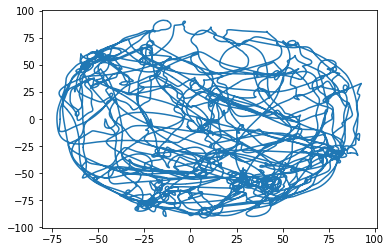

In [3]:
pos_x = np.array(posedata['X']*100) # convert to cm
pos_y = np.array(posedata['Y']*100)

# exclude first 10 datapoints
pos_x = pos_x[10:]
pos_y = pos_y[10:]
pos_t = pos_t[10:]

dt = int(np.average(np.diff(pos_t)))
t = pos_t
time = [i * 1. for i in t if i < sim_len]

env_rad = np.max(pos_x)

#### Artifical grid input

In [9]:
# for every grid cell calculate centers of grid firing fields
for gc in range(N):
    grid_center = [(gc%Nx)*spacex, (gc//Nx)*spacey]
    centers = np.array([grid_center])
    for i in np.arange(env_rad//grid_space+1):
        i+=1
        y = np.around(np.sin(grid_phase)*(i*grid_space),2)
        x = np.around(np.cos(grid_phase)*(i*grid_space),2)
            
        # horizontal
        centers =np.vstack((centers,np.add(grid_center,(x,y))))
        centers =np.vstack((centers,np.add(grid_center,(-x,-y))))
    
    # 60 degrees
    c = np.array([grid_center])
    for horz in centers:
        for i in np.arange(env_rad//grid_space+1):
            i+=1
            y = np.around(np.sin(grid_phase+(np.pi/3))*(i*grid_space),2)
            x = np.around(np.cos(grid_phase+(np.pi/3))*(i*grid_space),2)

            c =np.vstack((c,np.add(horz,(x,y))))
            c =np.vstack((c,np.add(horz,(-x,-y))))
            c =np.vstack((c,np.add(horz,(-x,y))))
            c =np.vstack((c,np.add(horz,(x,-y))))
    centers =np.unique(np.vstack((centers,c)),axis=0)
    grids[gc] = centers

(-100.0, 100.0)

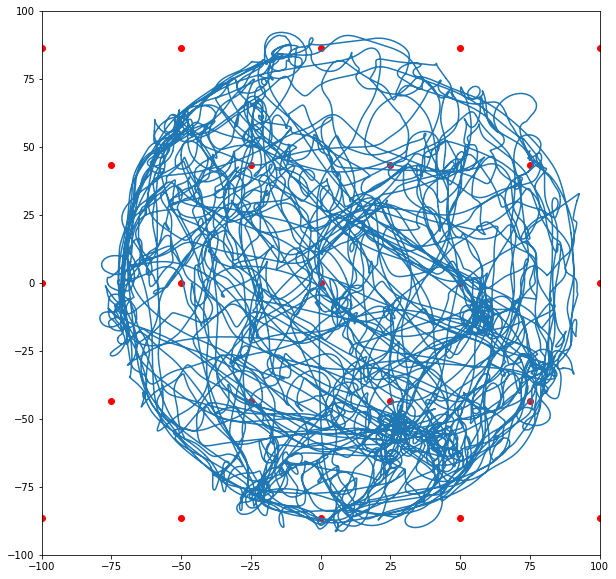

In [10]:
plt.figure(figsize=(10,10))
plt.plot(pos_x,pos_y)
plt.scatter(grids[0][:,0],grids[0][:,1],color = 'r')
plt.xlim([-100,100])
plt.ylim([-100,100])

In [11]:
# for each position find the closest grid center:
closest_gcs = np.zeros(len(time))*np.nan
for i in range(len(time)):
    x = pos_x[i]
    y = pos_y[i]
    min_d = 100000000000
    temp = None
    for gc in range(N):
        centers = grids[gc]
        d = min(np.sqrt((x - centers[:,0])**2 + (y - centers[:,1])**2))
        if d < min_d:
            min_d = d
            temp = gc
    closest_gcs[i] = temp

In [12]:
sigma_2 = .1
grid_cell_input = np.empty((len(closest_gcs),N))
for n,gc in enumerate(closest_gcs):
    x_gc = (gc%Nx) / Nx
    y_gc = y_dim*(gc//Nx)/ Ny
    for i in range(N): 
        x_i = (i%Nx) / Nx 
        y_i = y_dim*(i//Nx) / Ny

        d1 = np.sqrt(abs(x_gc - x_i)**2 + abs(y_gc - y_i)**2)
        d2 = np.sqrt(abs(x_gc - x_i - 0.5)**2 + abs(y_gc - y_i + y_dim)**2)
        d3 = np.sqrt(abs(x_gc - x_i - 0.5)**2 + abs(y_gc - y_i - y_dim)**2)
        d4 = np.sqrt(abs(x_gc - x_i + 0.5)**2 + abs(y_gc - y_i + y_dim)**2)
        d5 = np.sqrt(abs(x_gc - x_i + 0.5)**2 + abs(y_gc - y_i - y_dim)**2)
        d6 = np.sqrt(abs(x_gc - x_i - 1.)**2 + abs(y_gc - y_i)**2)
        d7 = np.sqrt(abs(x_gc - x_i + 1.)**2 + abs(y_gc - y_i)**2)
        
        d_ = min(d1,d2,d3,d4,d5,d6,d7)
        grid_cell_input[n,i] = (np.exp(-(d_)**2/2/sigma_2**2)*pred_gain)

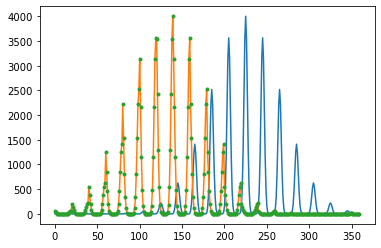

In [13]:
plt.plot(grid_cell_input[10,:])
plt.plot(grid_cell_input[20,:])
plt.plot(grid_cell_input[20,:],'.')

(0.0, 20.0)

<Figure size 360x360 with 0 Axes>

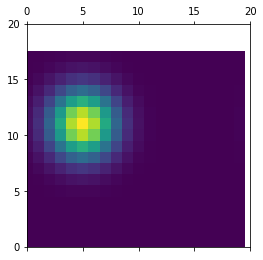

In [14]:
flat = grid_cell_input[10,:]
square = np.zeros((Ny,Nx))
for i in range(Ny):
    square[i,:] = flat[i*Nx:i*Nx+Nx]
plt.figure(figsize=(5,5))
plt.matshow(square)
plt.xlim([0,20])
plt.ylim([0,20])

In [15]:
view_input = sim.Create('step_current_generator', N)
for n in range(N):
    sim.SetStatus([view_input[n]],{'amplitude_times': time[1:],'amplitude_values': grid_cell_input[1:,n]})
    
sim.Connect(view_input,exc,'one_to_one')

### Record spikes

In [16]:
exc_spikes = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True, "to_file": True, "label": "gc_spikes"})
sim.Connect(exc,exc_spikes)

### Init bump

In [17]:
bump_init = sim.Create('step_current_generator', 1, params = {'amplitude_times':[0.1,0.1+I_init_dur],'amplitude_values':[I_init,0.0]})
sim.Connect(bump_init,[exc[216]])

### Run simulation

In [18]:

print(f'Starting simulation in {sim_len/chunk} chunks. Saving to {folder}')

sim.Prepare()
for i in np.arange(sim_len/chunk):
    sim.Run(chunk)
    print(f'Chunk {i} complete...')
sim.Cleanup()
print(f'Simulation run time: {np.around(tm.time()-tic,2)}s  Simulated time: {np.around(sim_len/1000,2)}s')

Starting simulation in 1.0 chunks. Saving to rat_600000ms_2022-04-26_12:02:17_gain_4000
Chunk 0.0 complete...
Simulation run time: 2978.79s  Simulated time: 600.0s


In [19]:
for file in os.listdir(path):
    if file.endswith(".gdf"):
        data = pd.read_csv(f'{path}/{file}', delimiter="\t")
        data = data.drop(columns=['Unnamed: 2'])
        data = data.set_axis(['sp','t'], axis=1, inplace=False)
        sp = np.array(data['sp'])
        t = np.array(data['t'])

print(f'Spikes reloaded. Plotting...')

Spikes reloaded. Plotting...


196
Plot saved rat_600000ms_2022-04-26_12:02:17_gain_4000/spikes.png


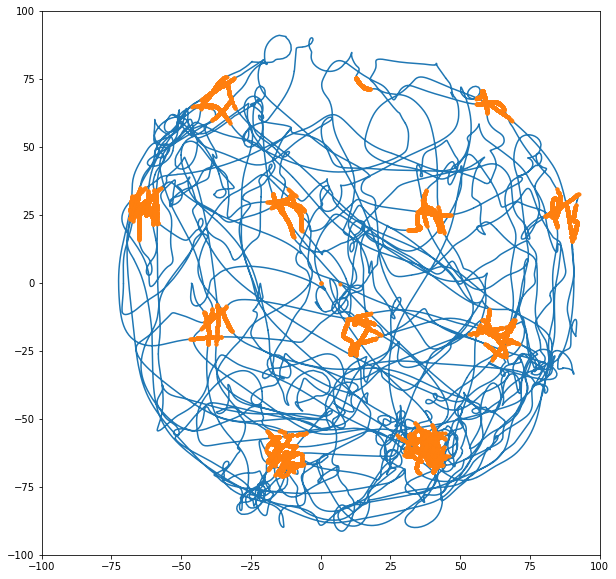

In [20]:
# occurence_count = Counter(sp) 
# # print(occurence_count)
# cell = occurence_count.most_common(5)[0][0]
# print(cell)

cell = 243

spktms = t[sp==cell]
spktms = (spktms//20)*20
spktms=spktms[1:]

xs = np.empty((len(spktms)))
ys = np.empty((len(spktms)))

for i,spk in enumerate(spktms):
    try:
        xs[i] = pos_x[np.where(time == spk)[0][0]]
        ys[i] = pos_y[np.where(time == spk)[0][0]]
    except:
        a=1

fig = plt.figure(figsize=(10, 10),facecolor='w')
plt.plot(pos_x[:len(time)],pos_y[:len(time)])
plt.plot(xs,ys,'.')
plt.xlim([-100,100])
plt.ylim([-100,100])

plt.savefig(f'{path}/spikes.png')

print(f'Plot saved {path}/spikes.png')

In [ ]:
dictparams = {'gain': gain, 
              'sh':sh, 
              'base_cj':base_cj, 
              'Nx':Nx, 
              'Ny':Ny, 
              'sigma':sigma, 
              'mu':mu, 
              'delay':delay, 
              'base_ex':base_ex, 
              'base_in':base_in,
              'w_ex_cj':w_ex_cj,
              'y_dim':y_dim,
              'pred_gain':pred_gain,
              'grid_space':grid_space,
              'grid_phase':grid_phase
             }

np.save(f'{path}/params',dictparams)

In [21]:
prm = dict()
prm['pixel_ratio'] = 440
prm['output_path'] = f'{path}/'

In [22]:
spike_data = pd.DataFrame()

cells = [cell]
for cell in cells: #set(sp):
    spktms = t[sp==cell]
    spktms = (spktms//20)*20

    xs = np.empty((len(spktms)))
    ys = np.empty((len(spktms)))

    for i,spk in enumerate(spktms):
        if spk < 60000:
            xs[i] = pos_x[np.where(time == spk)[0][0]]
            ys[i] = pos_y[np.where(time == spk)[0][0]]

    spike_data = spike_data.append({'cell_id': int(cell),
                                    'spike_times': spktms, 
                                    'number_of_spikes': len(spktms),
                                    'mean_firing_rate': len(spktms)/(sim_len/1000),
                                    'position_x': xs - min(pos_x),
                                    'position_y': ys - min(pos_y),
                                    'position_x_pixels' : (xs - min(pos_x)) / 100 * prm['pixel_ratio'],
                                    'position_y_pixels' : (ys - min(pos_y)) / 100 * prm['pixel_ratio']
                                    }, ignore_index=True)

spike_data.to_pickle(f'{path}/spike_data.pkl')

In [23]:
spatial_data = dict()
spatial_data['position_x'] = pos_x - min(pos_x)
spatial_data['position_y'] = pos_y - min(pos_y)

# pixels = cm / 100 * prm['pixel_ratio']
spatial_data['position_x_pixels'] = spatial_data['position_x'] / 100 * prm['pixel_ratio']
spatial_data['position_y_pixels'] = spatial_data['position_y'] / 100 * prm['pixel_ratio']

spatial_data = pd.DataFrame.from_dict(spatial_data)
spatial_data.to_pickle(f'{path}/spatial_data.pkl')

I will plot a heat map of the position of the animal to show coverage.


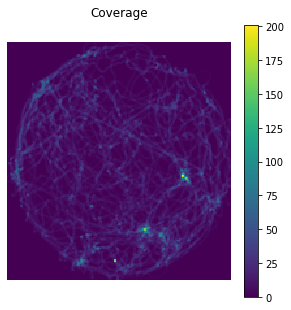

In [24]:
position_heat_map = griddy.get_position_heatmap(spatial_data, prm)
griddy.plot_coverage(position_heat_map, prm)

In [25]:
if not 'firing_maps' in spike_data:
    position_heat_map, spike_data = griddy.make_firing_field_maps(spatial_data, spike_data, prm)

I will calculate firing rate maps now.
Started another cluster
0
Making the rate maps took:
188.86184668540955


I will make rate map plots.


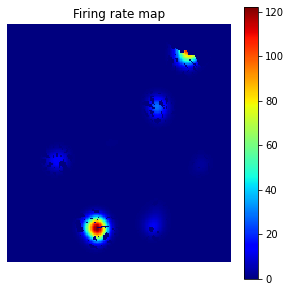

In [26]:
# plot firing rate maps
griddy.plot_firing_rate_maps(spike_data, prm)

In [27]:
spike_data = griddy.process_grid_data(spike_data)
spike_data.to_pickle(f'{path}/spike_data.pkl')

/mnt/c/Users/rsten/Documents/BRL/Projects/attractor-models-HD-grid/Grid/Feb2022/apr22_random_walk/grid_analysis.py:278: RuntimeWarning:invalid value encountered in multiply
